In [1]:
# Read summary of Pb SO-CI results from file "Pb_SOCI_results.xlsx"

import sys, os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, r'../../atomic_SOC')
import chem_subs as chem

In [2]:
def read_datafile(fname):
    # read data from CSV or Excel file
    froot = os.path.split(fname)[-1]
    if 'xlsx' in fname:
        xl = pd.ExcelFile(fname)
        if len(xl.sheet_names) > 1:
            print('Available worksheets:', xl.sheet_names)
            sheet = input('\tchoose a worksheet: ')
        else:
            sheet = xl.sheet_names[0]
        print(f'Reading worksheet "{sheet}" from Excel file {froot}')
        df = xl.parse(sheet, header=None)
    return sheet, df

In [3]:
datadir = r'C:\Users\irikura\OneDrive - NIST\Karl\atomic_SOC\MSS'
datafile = 'Pb_SOCI_results.xlsx'
fdata = os.sep.join([datadir, datafile])
# Data selection flags
use_PP = True  # use results from pseudopotential calculations
use_AE = True  # use results from all-electron calculations 

In [4]:
print(f'Reading SO-CI data from {fdata}')
xl = pd.ExcelFile(fdata)
df_letters = xl.parse('letter codes', skiprows=1)
ncalc = len(df_letters)
print(f'There are results for {ncalc} calculations')
re_num = re.compile(r'\d\d+')
# Check that filenames are consistent with other descriptors
nbad = 0
iPPl = []  # rows with PP basis set
iAEl = []  # rows with AE basis set
for irow, row in df_letters.iterrows():
    fn = row['Filename']
    # basis set
    bas = row['Basis set']
    bad = False
    if 'pp' in bas:
        iPPl.append(irow)
        if bas not in fn:
            bad = True
    else:
        # all-electron calculation
        iAEl.append(irow) 
        if 'pp' in fn:
            bad = True
        else:
            # remove suffix
            for suf in ['dk3', 'dk', 'x2c']:
                bas = bas.replace(suf, '')
            if bas not in fn:
                bad = True
    if bad:
        print(f'*** basis = {bas} for filename = {fn} looks wrong ***')
        nbad += 1
        continue  # don't check this filename further
    # multi-digit numbers in filename should be 3P weight or active space
    numl = re_num.findall(fn)
    if len(numl):
        wt = str(row['3P wt in CASSCF'])
        acts = row['Active space'].replace(')', '').replace('(', '').replace('/', '')
        for num in numl:
            if (wt != num) and (acts != num):
                print(f'*** filname {fn} does not match active space {row["Active space"]} or 3P weight {wt}')
                nbad += 1
if nbad:
    print(f'*** There are {nbad} questionable filenames ***')
else:
    print('Filenames look fine')

Reading SO-CI data from C:\Users\irikura\OneDrive - NIST\Karl\atomic_SOC\MSS\Pb_SOCI_results.xlsx
There are results for 34 calculations
Filenames look fine


In [5]:
# Apply restrictions (PP, AE)
if not use_PP:
    df_letters = df_letters.drop(iPPl)
    print(f'*** dropping {len(iPPl)} PP calculations')
if not use_AE:
    df_letters = df_letters.drop(iAEl) 
    print(f'*** dropping {len(iAEl)} AE calculations')

In [6]:
df_letters.head()

,Calc,Terms,3P wt in CASSCF,Basis set,Active space,Raw Eso,Filename,eq. (2),Comments
0,A,"3(P,D,P,S) + 1(D,S,P,D,S)",1,actzpp,(4/7),-10883.89,pb_3PDPS1DSPDS_actzpp.pro,-11509.75,"err(J=1,2) = -598, -444"
1,B,"3(P,D,P,S) + 1(D,S,P,D,S)",1,acqzpp,(4/7),-11102.42,pb_3PDPS1DSPDS_acqzpp.pro,-11507.83,"err(J=1,2) = -379, -231. Levels above 50000 c..."
2,D,"3(P,D,P,S) + 1(D,S,P,D,S)",1,ac5zpp,(4/7),-11166.40,pb_3PDPS1DSPDS_ac5zpp.pro,-11512.28,"(cf. M) (48.7 hrs) err(J=1,2) = -326, -174; er..."
3,F,3P + 1D,1,actzdk3,(4/4),-11440.81,pb_3P1D_actz.pro,-11550.90,"err(J=1,2) = -2099, -1622 (and J=2 is led by 1..."
4,G,3P + 1D,1,acqzdk3,(4/4),-11725.99,pb_3P1D_acqz.pro,-11568.02,"(1 hour) err(J=1,2) = -1956, -1452 (1D as abov..."


In [7]:
# Read all the data pages
dfd = {}  # key = letter code, value = DataFrame
for lett in df_letters.Calc:
    dfd[lett] = xl.parse(lett)

In [8]:
incols = df_letters.columns
dfout = df_letters[incols[:7]].copy()

### Compute energy of 3P term using exptl energy levels

In [9]:
Esol = []
nround = 1  # number of decimals (cm-1)
tol = 0.1 ** nround  # cm-1
nbad = 0
for icalc, row in df_letters.iterrows():
    lett = row['Calc']
    df = dfd[lett]
    wcol = '(1)3P'
    if wcol not in df.columns:
        wcol = '3P'
    wts = df[wcol].values
    levs = df['Expt/cm-1'].values
    Eso = - np.dot(wts, levs) / wts.sum()
    eq2 = df_letters.at[icalc, "eq. (2)"]  # value from the summary spreadsheet
    if abs(Eso - eq2) > tol:
        # print warning
        print(f'*** For calc {lett:<3s}, Eso = {Eso:.1f} is different from ealier value {eq2:.1f} ***')
        nbad += 1
    Esol.append(Eso)
dfout['Eso'] = np.round(Esol, nround)
if nbad:
    print(f'*** Current evaluation of eq. (2) differs from earlier in {nbad} cases ***')
else:
    print('Current evaluation of eq. (2) agrees with earlier values')

Current evaluation of eq. (2) agrees with earlier values


### Compute weighted unsigned error of 3P-derived level energies

In [10]:
werrl = []
for icalc, lett in enumerate(dfd.keys()):
    df = dfd[lett]
    wcol = '(1)3P'
    if wcol not in df.columns:
        wcol = '3P'
    wts = df[wcol].values
    uerr = np.abs(df['err'].values)
    werr = np.dot(wts, uerr) / wts.sum()
    werrl.append(werr)
dfout['wtd uerr'] = np.round(werrl, nround)

In [11]:
# Discard calculations with excessive error in 3P level energies 
max_uerr = 1500.  # only use calculations with smaller values of the weighted, unsigned error in 3P levels
nbig = len(dfout[dfout['wtd uerr'] > max_uerr])
if nbig:
    print(f'Discarding {nbig} calculations because their energy errors > {max_uerr} cm-1')
    dfout = dfout[dfout['wtd uerr'] <= max_uerr]

Discarding 15 calculations because their energy errors > 1500.0 cm-1


In [12]:
# Show all results, sorted by increasing weighted, unsigned error in 3P level energies
print(f'{len(dfout)} calculations are being considered (sorted by energy error):')
dfout.sort_values('wtd uerr')

19 calculations are being considered (sorted by energy error):


,Calc,Terms,3P wt in CASSCF,Basis set,Active space,Raw Eso,Filename,Eso,wtd uerr
21,X,"3(P,D,P,S) + 1(D,S,P,D,S)",1,tac5zpp,(4/7),-11177.12,pb_3PDPS1DSPDS_tac5zpp.pro,-11503.3,339.9
10,M,"3(P,D,P,S) + 1(D,S,P,D,S)",1,dac5zpp,(4/7),-11176.85,pb_3PDPS1DSPDS_dac5zpp.pro,-11503.5,340.5
2,D,"3(P,D,P,S) + 1(D,S,P,D,S)",1,ac5zpp,(4/7),-11166.40,pb_3PDPS1DSPDS_ac5zpp.pro,-11512.3,361.3
32,AI,"3(P,D,P,S) + 1(D,S,P,D,S)",1,dac5zpp,(4/8),-11147.50,pb_3PDPS1DSPDS_dac5zpp_48.pro,-11495.0,361.6
13,P,"3(P,D,P,S) + 1(D,S,P,D,S)",1,tacqzpp,(4/7),-11116.38,pb_3PDPS1DSPDS_tacqzpp.pro,-11495.9,392.9
11,N,"3(P,D,P,S) + 1(D,S,P,D,S)",1,dacqzpp,(4/7),-11116.10,pb_3PDPS1DSPDS_dacqzpp.pro,-11496.2,393.5
1,B,"3(P,D,P,S) + 1(D,S,P,D,S)",1,acqzpp,(4/7),-11102.42,pb_3PDPS1DSPDS_acqzpp.pro,-11507.8,421.0
14,Q,"3(P,D,P,S,P) + 1(D,S,P,D,S)",1,tacqzpp,(4/7),-11083.07,pb_3PDPSP1DSPDS_tacqzpp.pro,-11531.0,465.9
31,AH,"3(P,D,P,S) + 1(D,S,P,D,S)",1,dac5zpp,(2/6),-10914.20,pb_3PDPS1DSPDS_dac5zpp_26.pro,-11457.6,555.8
23,Z,"3(P,D,P,S) + 1(D,S,P,D,S)",1,usp-dacqzpp,(2/6),-10880.07,pb_3PDPS1DSPDS_usp-dacqzpp_26.pro,-11453.8,585.8


Uncertainty as weighted unsigned error in computed 3P level energies


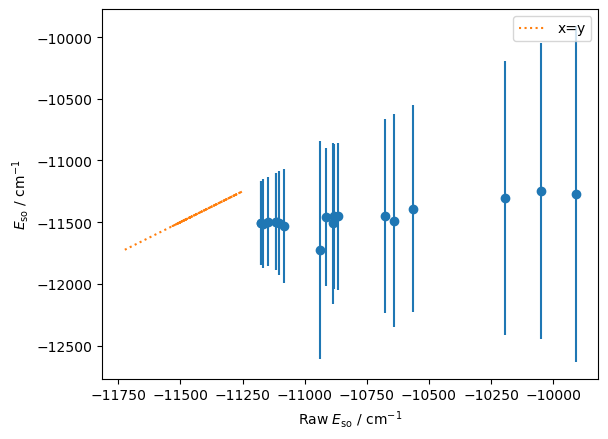

In [13]:
# Choose values for uncertainties
print('Uncertainty as weighted unsigned error in computed 3P level energies')
yunc = dfout['wtd uerr']
plt.errorbar(dfout['Raw Eso'], dfout['Eso'], yerr=yunc, fmt='o')
plt.ylabel(r'$E_\mathrm{so}$ / cm$^{-1}$')
plt.xlabel(r'Raw $E_\mathrm{so}$ / cm$^{-1}$')
# show y=x line
plt.plot(dfout['Eso'], dfout['Eso'], ls=':', label='x=y')
plt.legend()
plt.show()

In [14]:
print('Unweighted stats for raw and eq. (2) values of Eso:')
xraw = dfout["Raw Eso"].values
xeq2 = dfout['Eso'].values
mraw = xraw.mean()
meq2 = xeq2.mean()
dfu = pd.DataFrame({'mean': np.round([mraw, meq2], nround), 
                   'stds': np.round([xraw.std(ddof=1), xeq2.std(ddof=1)]),
                   'range': np.round([np.ptp(xraw), np.ptp(xeq2)], nround)},
                   index=['raw', 'eq. (2)'])
display(dfu)
print(f'    Means differ by {mraw - meq2:.1f}')

Unweighted stats for raw and eq. (2) values of Eso:


,mean,stds,range
raw,-10821.0,393.0,1268.0
eq. (2),-11462.8,105.0,473.9


    Means differ by 641.7


In [15]:
print(f'Number of calculations considered = {len(dfout)}')
for p in [-1, -2, -0.5]:
    print(f'Weighted stats for raw and eq. (2) values of Eso, weights = yunc**{p}:')
    mraw, uraw = chem.weighted_mean(xraw, yunc**p)
    meq2, ueq2 = chem.weighted_mean(xeq2, yunc**p)
    dfw = pd.DataFrame({'wmean': np.round([mraw, meq2], nround), 
                       'wstds': np.round([uraw, ueq2], nround)},
                       index=['raw', 'eq. (2)'])
    #dfw.loc['diff'] = [xraw - xeq2, 0]
    display(dfw)
    print(f'    Means differ by {mraw - meq2:.1f}')

Number of calculations considered = 19
Weighted stats for raw and eq. (2) values of Eso, weights = yunc**-1:


,wmean,wstds
raw,-10954.9,60.1
eq. (2),-11482.1,13.7


    Means differ by 527.2
Weighted stats for raw and eq. (2) values of Eso, weights = yunc**-2:


,wmean,wstds
raw,-11040.7,39.3
eq. (2),-11492.5,7.5


    Means differ by 451.8
Weighted stats for raw and eq. (2) values of Eso, weights = yunc**-0.5:


,wmean,wstds
raw,-10894.0,74.1
eq. (2),-11473.7,18.4


    Means differ by 579.7
